In [2]:
import dill
import arviz as az
import pandas as pd
import numpy as np
import datetime
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt

RANDOM_SEED = 42

def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

def reparameterize(pi):
    return pi / pi.sum()

def hierarchical_beta(alpha0, beta, nsources, k):
    """Hierarchical Beta distribution for multiple sources."""
    pi_tilt_sources = []
    
    for s in range(nsources):
        beta_params = [(alpha0 * beta[k], alpha0 * (1 - pm.math.sum(beta[:k + 1]))) for k in range(k)]
        pi_tilt = pm.Beta(f'pi_tilt_{s}', 
                          alpha=[b[0] for b in beta_params], 
                          beta=[b[1] for b in beta_params], 
                          dims="component")
        pi_tilt_sources.append(pi_tilt)
    
    #return pm.math.stack(pi_tilt_sources, axis=0)
    return pi_tilt_sources

In [3]:
np.random.seed(123)

# Parameters
N_settings = 1
n = 1000  # Total number of samples
N_components = 3  # Number of components for each setting
N_sources = 8  # Number of sources
sigma = 0.01  # Standard deviation for the noise
a = np.random.normal(0, 1, size=N_components)  # Intercepts from N(0, 1)
b = np.random.normal(0.5, 1, size=N_components)  # Slopes from N(0.5, 1)
# Dirichlet alpha parameter (controls the distribution of proportions)
alpha = np.ones(N_components)
Proportions = []

for i in range(N_sources):
    Proportions.append(np.random.dirichlet(alpha))

# Function to generate dataset with varying intervals and Dirichlet proportions
def Generate_dataset_HDP_random_components(n, N_sources, N_components, b, a, sigma):
    # Initialize lists to store data
    X = []
    Y = []
    components = []  # To store component labels for each data point

    # Generate data for each source
    for j in range(N_sources):
        X_source = []
        Y_source = []
        component_labels = []  # Component labels for this source

        # Sample proportions from Dirichlet distribution
        proportions = Proportions[j]

        # Randomly assign components to all samples for this source
        assigned_components = np.random.choice(
            np.arange(N_components), 
            size=n, 
            p=proportions  # Use Dirichlet proportions as probabilities
        )
        
        # Generate data for each component
        for i in range(N_components):
            size_i = np.sum(assigned_components == i)  # Number of samples for this component
            X_component = np.random.uniform(-10, 10, size=(size_i, 1))
            e_component = np.random.normal(0, sigma, size=(size_i, 1))
            Y_component = b[i] * X_component + a[i] + e_component

            X_source.append(X_component)
            Y_source.append(Y_component)
            component_labels.extend([i] * size_i)  # Append component labels

        # Store combined data for the source
        X.append(np.vstack(X_source))
        Y.append(np.vstack(Y_source).ravel())
        components.append(np.array(component_labels))  # Convert to NumPy array for consistency

    return X, Y, components

# Generate datasets for each setting with correct component labels
X = []
Y = []
components = []

for i in range(N_settings):
    X_setting, Y_setting, components_setting = Generate_dataset_HDP_random_components(
        n, 
        N_sources, 
        N_components, 
        b, 
        a, 
        sigma
    )
    X.append(X_setting)
    Y.append(Y_setting)
    components.append(components_setting)

Plotting Y vs X for Setting 1


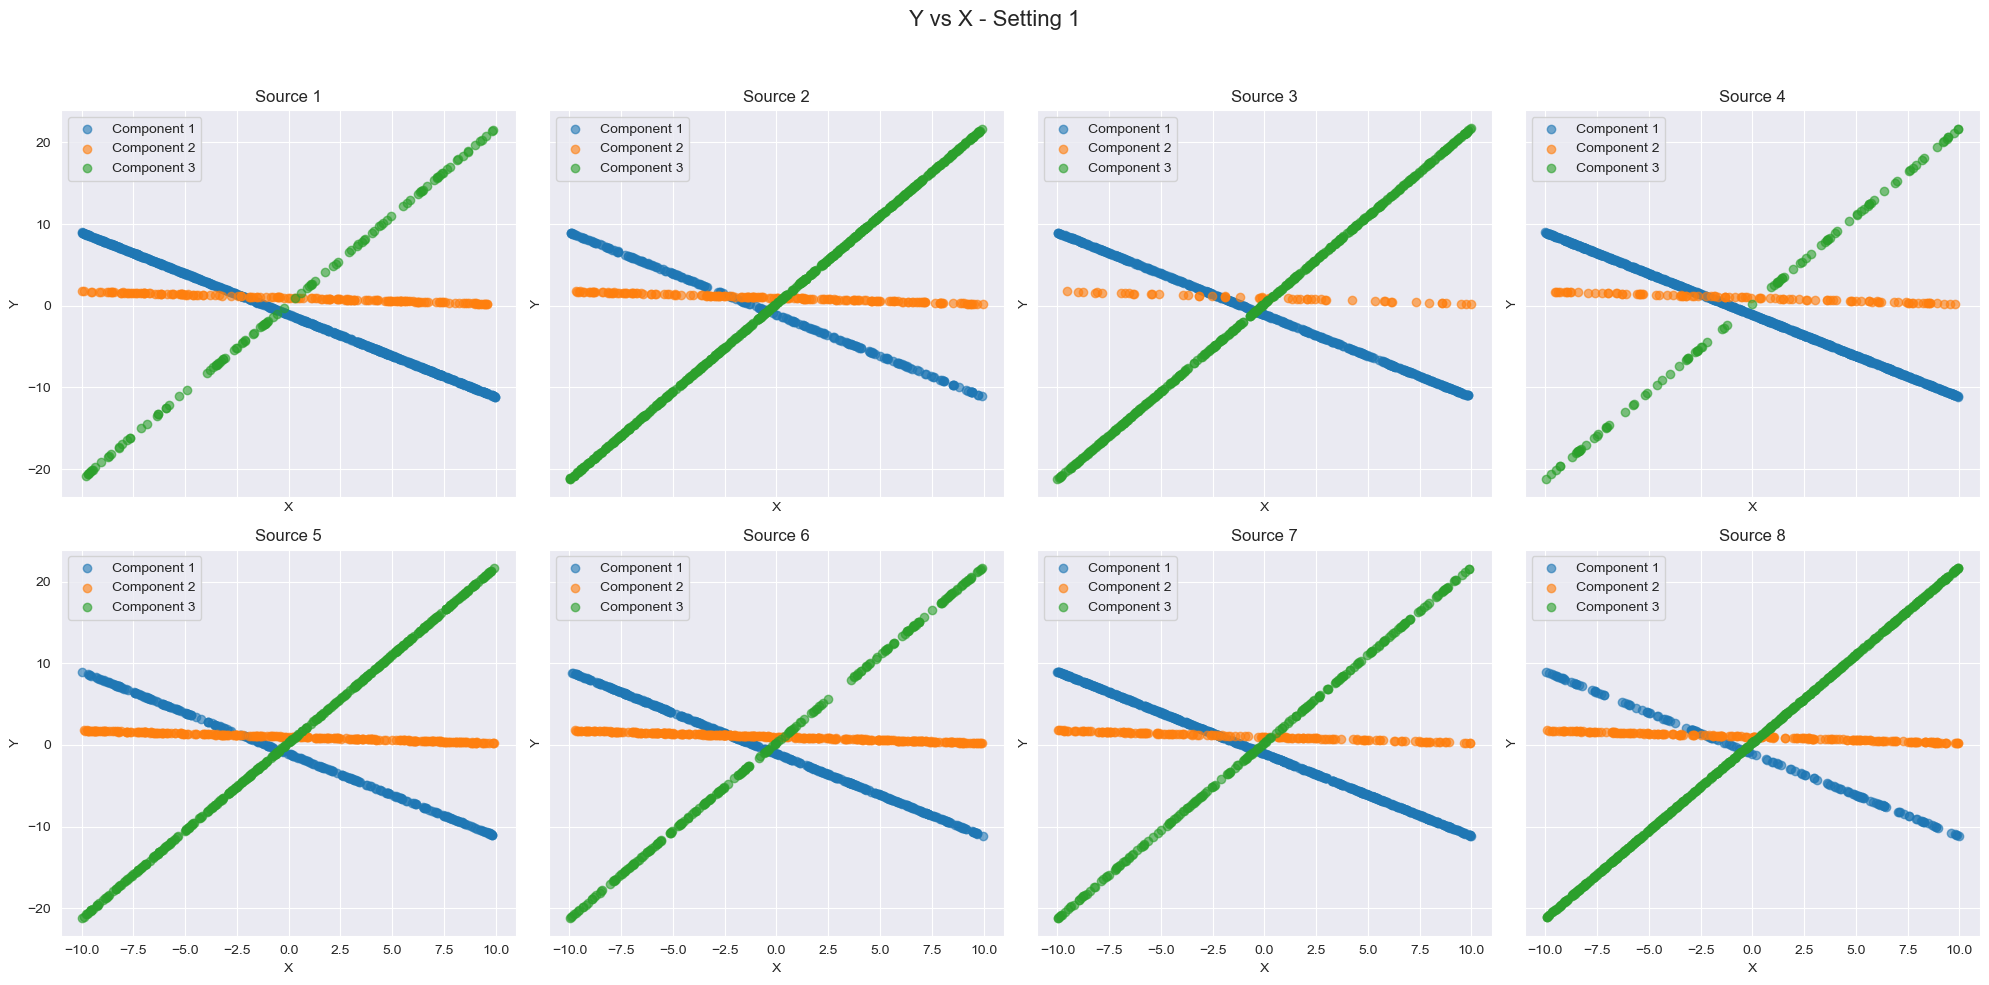

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Plotting Y vs X for each source with components in different colors (2 rows layout)
for setting_idx, (X_setting, Y_setting, components_setting) in enumerate(zip(X, Y, components)):
    print(f"Plotting Y vs X for Setting {setting_idx + 1}")
    
    # Determine the number of rows and columns for the grid layout
    n_cols = int(np.ceil(N_sources / 2))  # Two rows
    n_rows = 2 if N_sources > 1 else 1
    
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=True, sharex=True)
    fig.suptitle(f"Y vs X - Setting {setting_idx + 1}", fontsize=16)
    
    # Flatten axes for easy indexing
    axes = axes.flatten() if N_sources > 1 else [axes]
    
    for source_idx, (X_source, Y_source, component_labels) in enumerate(zip(X_setting, Y_setting, components_setting)):
        ax = axes[source_idx]
        X_source = X_source.ravel()  # Flatten X_source
        
        # Scatter plot with different colors for each component
        for comp_idx in range(N_components):
            ax.scatter(
                X_source[component_labels == comp_idx],  # X values for the component
                Y_source[component_labels == comp_idx],  # Y values for the component
                label=f"Component {comp_idx + 1}",
                alpha=0.6
            )
        
        ax.set_title(f"Source {source_idx + 1}")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.legend()
    
    # Remove unused subplots
    for idx in range(len(X_setting), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate the title
    plt.show()

In [5]:
ks = [5, 5, 5]  # Number of components
models = []
traces = []

# Perform analysis for each setting
for i in range(N_settings):
    print(f"Running model for setting {i + 1}, total settings: {N_settings}")
    model_name = f"HDP_model_{i + 1}"
    
    with pm.Model(coords={"component": np.arange(ks[i]), "n_source": np.arange(N_sources)}) as locals()[model_name]:
        # Priors for weight parameters
        gamma = pm.Gamma("gamma", 1.0, 5.0)
        alpha0 = pm.Gamma("alpha0", 1.0, 5.0)
        beta_tilt = pm.Beta("beta_tilt", 1.0, gamma, dims="component")  # Generate beta values
        beta = pm.Deterministic("beta", stick_breaking(beta_tilt), dims="component")
        π_tilt = hierarchical_beta(alpha0, beta, nsources=N_sources, k=ks[i])  # Component weights
        
        π_norms = []
        for s in range(N_sources):
            π = pm.Deterministic(f"π_{s}", stick_breaking(π_tilt[s]), dims="component")
            π_norms.append(pm.Deterministic(f"π_norm_{s}", reparameterize(π), dims=["component"]))
        
        # Priors for unknown model parameters
        α = pm.Normal('α', mu=0, sigma=100, shape=(1, ks[i]))  # Intercepts
        β = pm.Normal('β', mu=0, sigma=100, shape=(1, ks[i]))  # Slopes
        σ = pm.HalfCauchy('σ', 1, shape=ks[i])  # Noise
        
        # Likelihood
        likelihood = []
        for s in range(N_sources):
            mu = α + β * X[i][s]
            likelihood.append(pm.NormalMixture(f'likelihood_{s}', π_norms[s], mu, sigma=σ, observed=Y[i][s]))
        
        # Sampling
        trace = pm.sample(
            tune=5000,
            draws=20000,
            init="adapt_diag",
            step=[pm.NUTS(target_accept=0.99,max_treedepth=30)],
            random_seed=RANDOM_SEED,
        )
         
    models.append(locals()[model_name])
    traces.append(trace)

Running model for setting 1, total settings: 1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gamma, alpha0, beta_tilt, pi_tilt_0, pi_tilt_1, pi_tilt_2, pi_tilt_3, pi_tilt_4, pi_tilt_5, pi_tilt_6, pi_tilt_7, α, β, σ]


Output()

Sampling 4 chains for 5_000 tune and 20_000 draw iterations (20_000 + 80_000 draws total) took 4696 seconds.
There were 68441 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [58]:
def summary_HDP(trace, model, N_sources=1, k=1):
    """
    Summarize and visualize the HDP model results.

    :param trace: Trace of the model
    :param model: The model being summarized
    :param N_sources: Number of sources
    :param k: Number of components for the model
    :return: None
    """
    # Variable names to summarize    
    var_names = ["α", "β", "σ", "gamma", "alpha0", "beta"]
    # Add π_norm for each source
    for s in range(N_sources):
        var_names.append(f"π_{s}")
        var_names.append(f"π_norm_{s}")
        
    # 
    print("True regression parameters:")
    print(f"Intercepts: {a}")
    print(f"Slopes: {b}")
    print(f"Proportions: \n")
    for i in range(N_sources):
        print(f"Source {i+1}: {Proportions[i]}")
    # Get the summary DataFrame
    summary_df = az.summary(trace, var_names=var_names, kind="stats")
    
    # Ensure full display of all rows
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(f"Summary for HDP model with {N_sources} sources and {k} components:")
        print(summary_df)
    print("Trace summary completed.")

    # Plot trace and posterior distributions
    az.plot_trace(trace, var_names=["α", "β", "σ", "gamma", "alpha0", "beta"])
    plt.show()

    '''
    with model:
        posterior_predictive = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)

    az.plot_posterior(trace, var_names=["α", "β", "σ", "gamma", "alpha0", "beta"])
    plt.show()

    az.plot_ppc(posterior_predictive, num_pp_samples=1000)
    plt.show()
    '''

    # Bar plot of posterior expected mixture weights
    fig, ax = plt.subplots(figsize=(8, 6))
    plot_w = np.arange(k) + 1  # Component indices
    for s in range(N_sources):
        weights = trace.posterior[f"π_norm_{s}"].mean(("chain", "draw"))
        ax.bar(
            plot_w - 0.5 + s * 0.1,  # Offset for sources
            weights,
            width=0.1, label=f"Source {s + 1}",
        )

    ax.set_xlim(0.5, k + 0.5)
    ax.set_xlabel("Component")
    ax.set_ylabel("Posterior expected mixture weight")
    ax.legend(title="Sources")
    plt.show() 

Summary for Setting 1:
True regression parameters:
Intercepts: [-1.0856306   0.99734545  0.2829785 ]
Slopes: [-1.00629471 -0.07860025  2.15143654]
Proportions: 

Source 1: [0.68577431 0.20041195 0.11381374]
Source 2: [0.22382557 0.18900826 0.58716617]
Source 3: [0.50356254 0.05367592 0.44276154]
Source 4: [0.77251571 0.11621492 0.11126937]
Source 5: [0.30051087 0.3007446  0.39874452]
Source 6: [0.45881545 0.31236646 0.22881809]
Source 7: [0.60435048 0.18390045 0.21174907]
Source 8: [0.16156711 0.21682749 0.6216054 ]
Summary for HDP model with 8 sources and 5 components:
               mean        sd   hdi_3%  hdi_97%
α[0, 0]       0.283     0.000    0.283    0.284
α[0, 1]       0.997     0.000    0.997    0.998
α[0, 2]      -1.085     0.000   -1.086   -1.085
α[0, 3]      -4.743   101.632 -196.840  185.168
α[0, 4]       5.072   101.943 -188.572  198.482
β[0, 0]       2.151     0.000    2.151    2.152
β[0, 1]      -0.079     0.000   -0.079   -0.079
β[0, 2]      -1.006     0.000   -1.006 

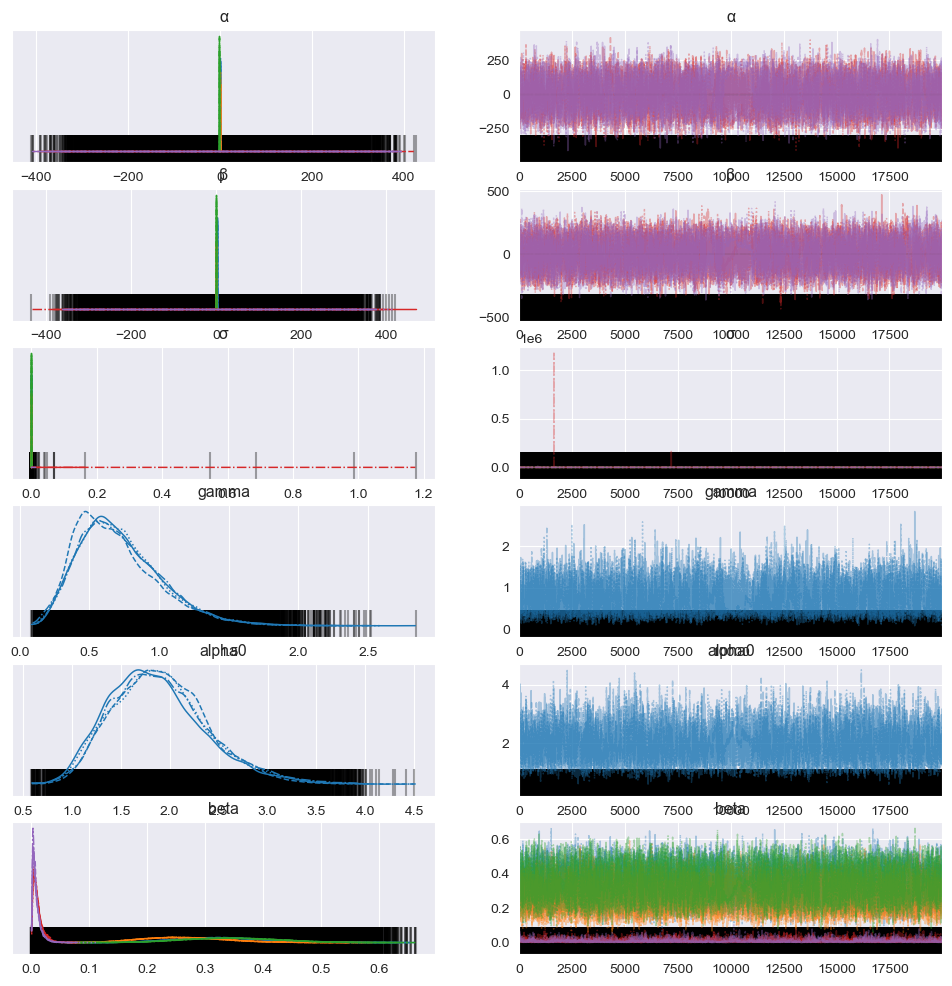

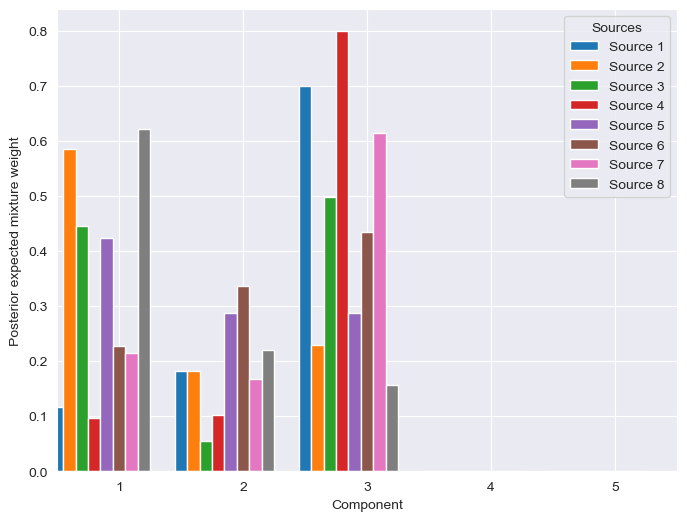

In [59]:
for i in range(N_settings):
    print(f"Summary for Setting {i + 1}:")
    summary_HDP(traces[i], models[i], N_sources=N_sources, k=ks[i])

In [60]:
# save results
datasets = (X, Y, Proportions)
#add date to the file name
now = datetime.datetime.now()
filename = "HDP_models_traces_" + now.strftime("%Y-%m-%d") + ".pkl"
with open(filename, "wb") as f:
    dill.dump((models, traces, datasets, a, b), f)

In [6]:
# Load results
with open("HDP_models_traces_2025-01-28.pkl", "rb") as f:
    models, traces, datasets, a, b = dill.load(f)
    X, Y, Proportions = datasets
    

Creating combined plots for setting 1


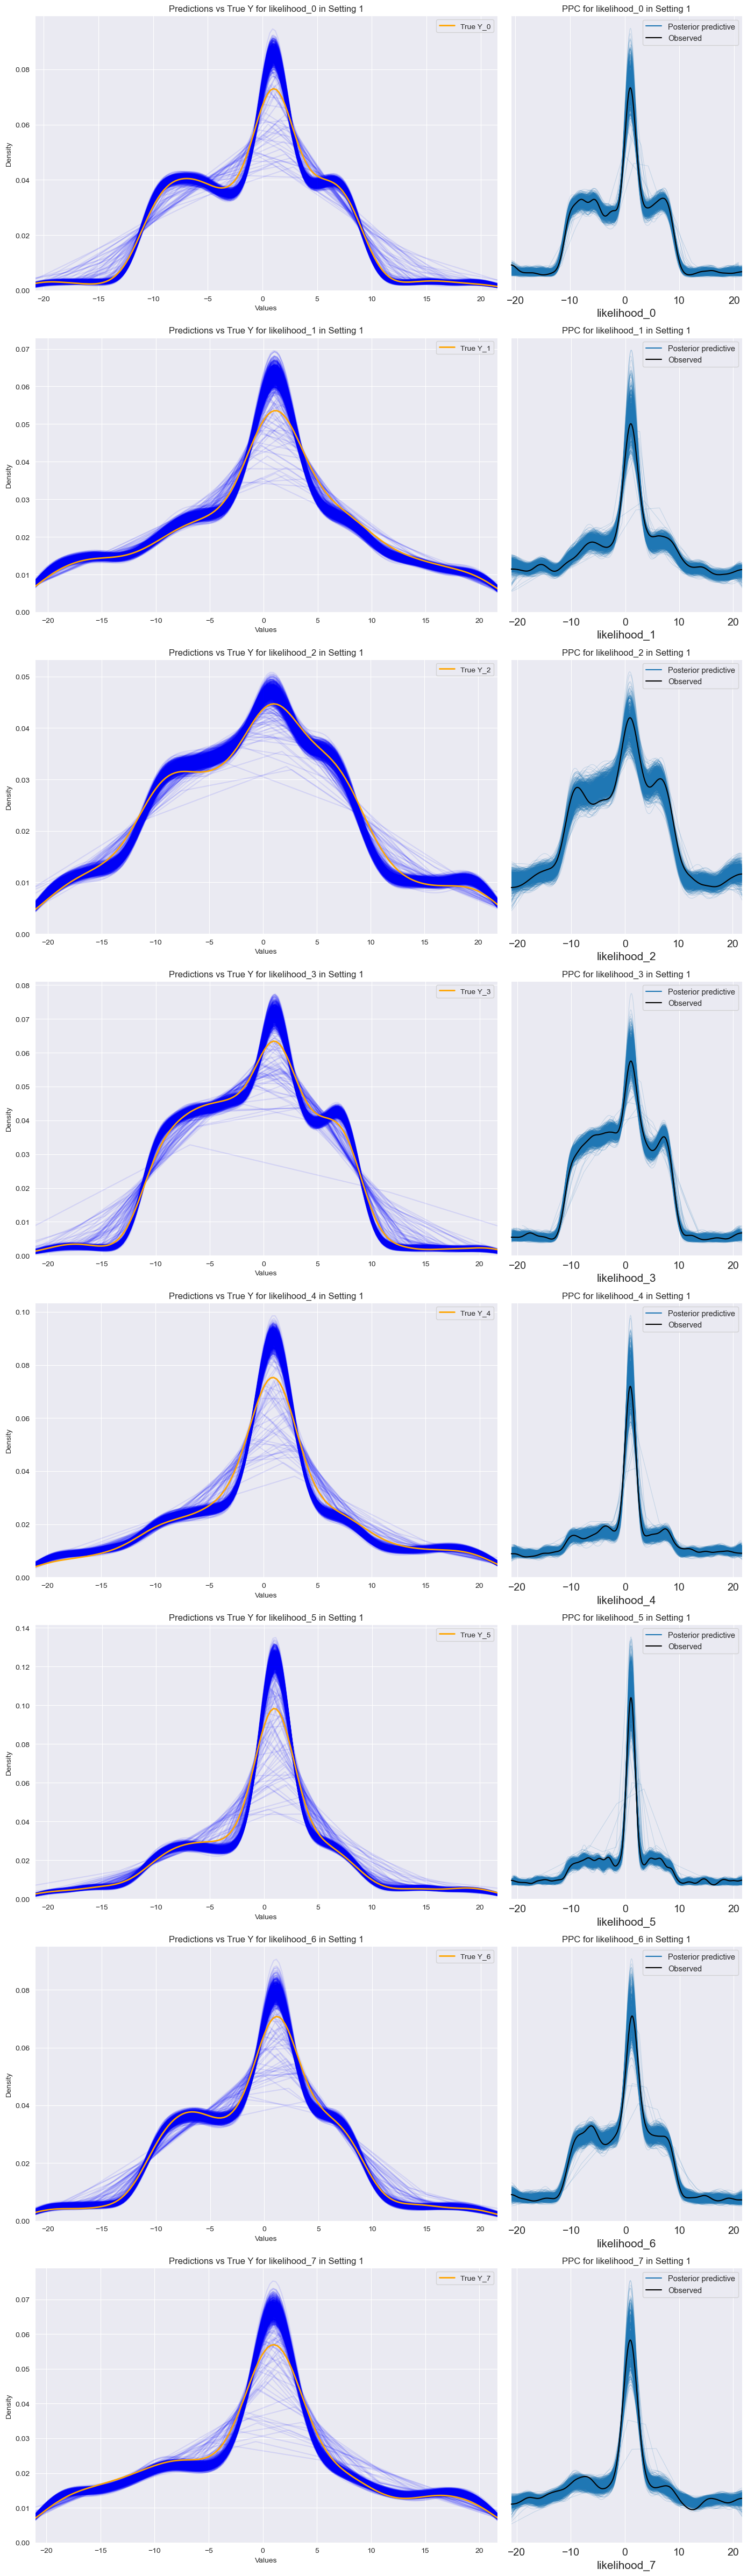

In [25]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

Predicted_values = [] 

for i in range(N_settings):
    print(f"Creating combined plots for setting {i + 1}")

    # 获取数据和后验预测
    X_setting = X[i]
    Y_setting = Y[i]
    
    with models[i]:
        posterior_predictive_setting = pm.sample_posterior_predictive(traces[i], random_seed=RANDOM_SEED)
    
    fig, axes = plt.subplots(N_sources, 2, figsize=(14, 6 * N_sources), gridspec_kw={'width_ratios': [2, 1]})
    if N_sources == 1:
        axes = [axes]  

    for s in range(N_sources):
        true_y = Y_setting[s]
        likelihood_name = f"likelihood_{s}"

        # Extract posterior predictive samples directly (shape: (4, 20000, 1000))
        predicted_values_full = posterior_predictive_setting.posterior_predictive[likelihood_name].values  # (4, 20000, 1000)
        predicted_values = predicted_values_full.reshape(-1, 1000)
        
        # Sample 1000 values from different draws and chains
        sampled_indices = np.random.choice(predicted_values_full.shape[1], size=1000, replace=False)  # Select 1000 draws
        predicted_values = predicted_values_full[:, sampled_indices, :].reshape(1000, -1)  # Keep separate density curves
        
        Predicted_values.append(predicted_values)

        # Determine x-axis limits
        all_values = np.concatenate([predicted_values.flatten(), true_y]) if true_y is not None else predicted_values.flatten()
        x_min, x_max = true_y.min(), true_y.max()

        # **Plot 1000 Density Curves (No Histogram)**
        ax = axes[s][0]
        for j in range(1000):
            sns.kdeplot(predicted_values[j], color="blue", alpha=0.1, ax=ax)

        if true_y is not None:
            sns.kdeplot(true_y, color="orange", label=f"True Y_{s}", linewidth=2, ax=ax)

        ax.set_title(f"Predictions vs True Y for {likelihood_name} in Setting {i + 1}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Density")
        ax.set_xlim(x_min, x_max)
        ax.legend()
        ax.grid(True)

        # **Ensure Correct az.plot_ppc Format**
        ax_ppc = axes[s][1]
        az.plot_ppc(posterior_predictive_setting, var_names=[likelihood_name], num_pp_samples=1000, ax=ax_ppc, mean=False)
        ax_ppc.set_title(f"PPC for {likelihood_name} in Setting {i + 1}")
        ax_ppc.set_xlim(x_min, x_max)

    plt.tight_layout()
    plt.show()


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize a list to store predictions and confidence intervals for all settings
predictions_with_ci = []

for i, trace in enumerate(traces):
    print(f"Generating predictions with confidence intervals for setting {i + 1}")
    
    # Generate posterior predictive samples
    with models[i]:
        ppc = pm.sample_posterior_predictive(trace, var_names=[f"likelihood_{s}" for s in range(N_sources)])
    
    # Store predictions and confidence intervals for each source
    setting_preds = []
    for s in range(N_sources):
        pred_samples = ppc.posterior_predictive[f"likelihood_{s}"]  # All posterior samples for this source
        pred_mean = pred_samples.mean(axis=0)
        pred_ci_lower = np.percentile(pred_samples, 2.5, axis=0)
        pred_ci_upper = np.percentile(pred_samples, 97.5, axis=0)
        
        setting_preds.append({
            "mean": pred_mean,
            "ci_lower": pred_ci_lower,
            "ci_upper": pred_ci_upper
        })
    predictions_with_ci.append(setting_preds)

Generating predictions with confidence intervals for setting 1


Sampling: [likelihood_0, likelihood_1, likelihood_2, likelihood_3, likelihood_4, likelihood_5, likelihood_6, likelihood_7]


Output()

Plotting predictions for Setting 1


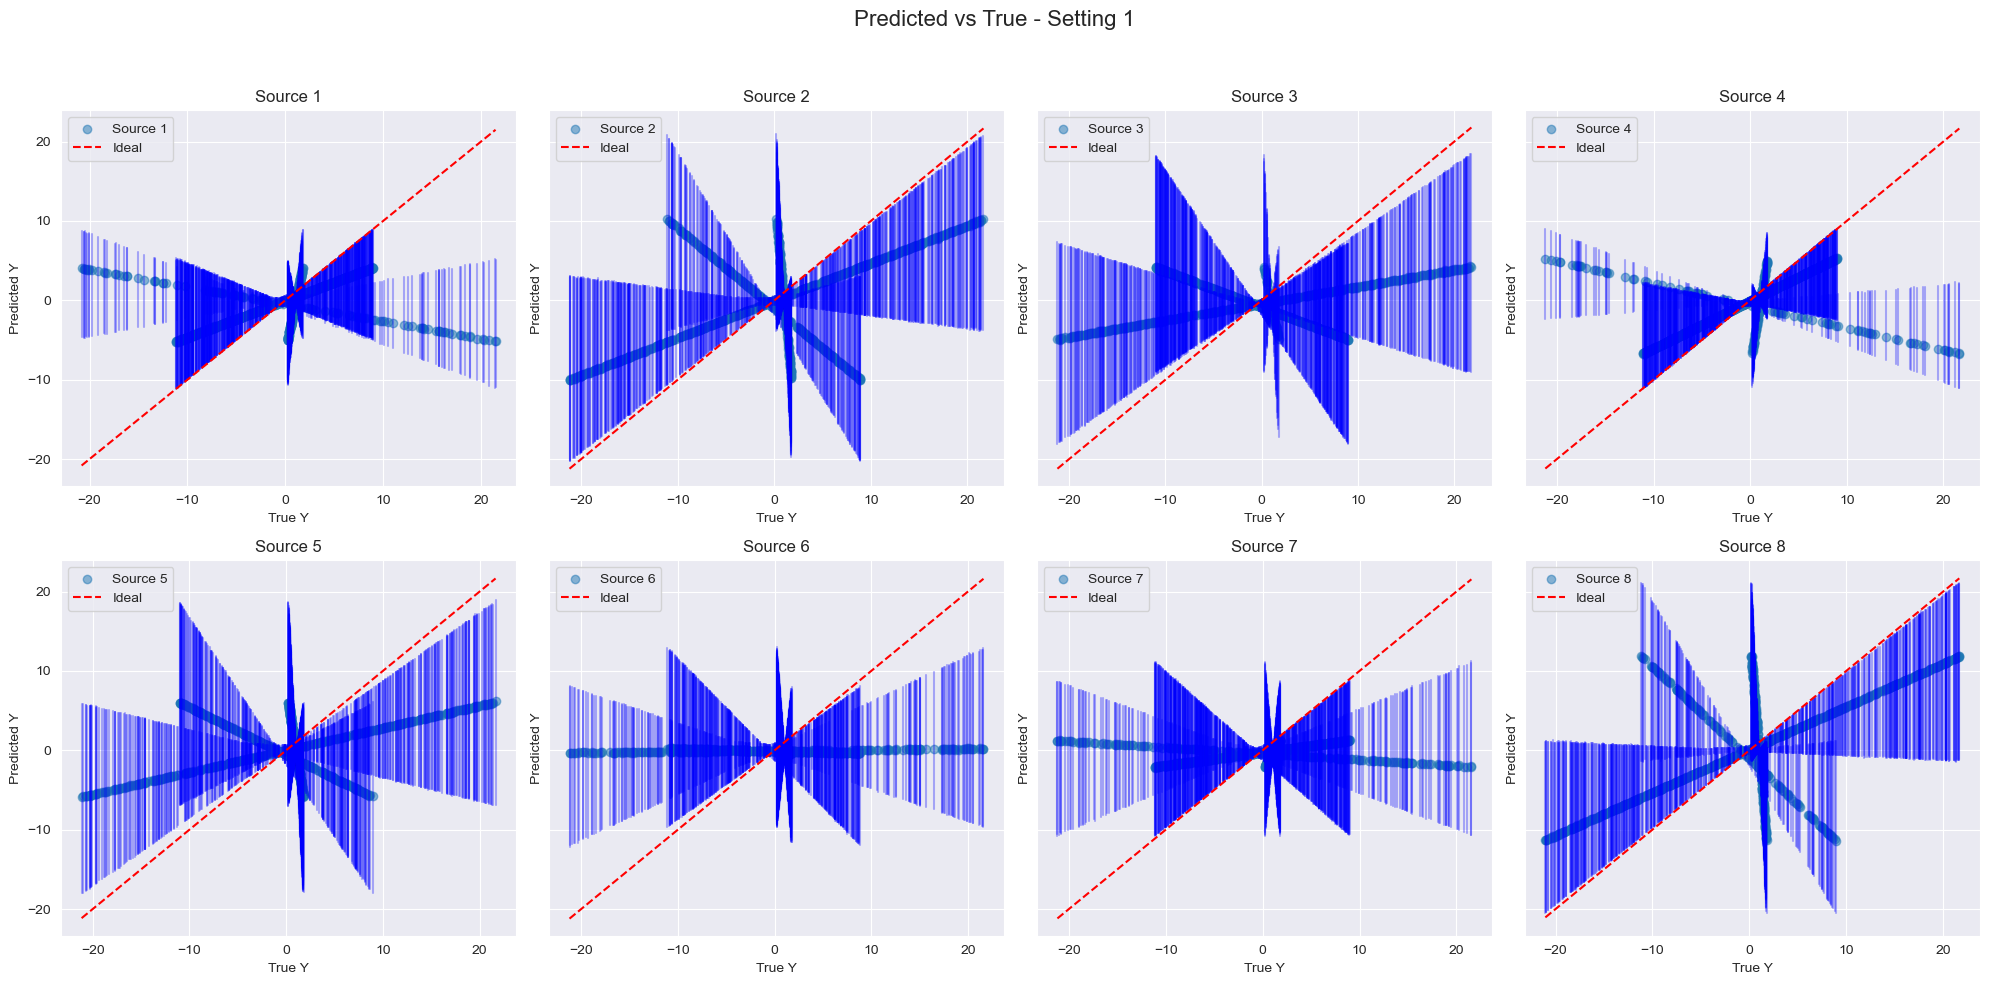

In [63]:
# Plot "Predicted vs True" for each setting with two rows of subplots
for setting_idx, (X_setting, Y_setting, preds) in enumerate(zip(X, Y, predictions_with_ci)):
    print(f"Plotting predictions for Setting {setting_idx + 1}")
    
    # Determine grid dimensions
    n_cols = int(np.ceil(N_sources / 2))  # Two rows
    n_rows = 2 if N_sources > 1 else 1   # Ensure at least one row

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=True)
    fig.suptitle(f"Predicted vs True - Setting {setting_idx + 1}", fontsize=16)
    
    # Flatten axes for easy indexing
    axes = axes.flatten() if N_sources > 1 else [axes]
    
    for source_idx, (X_source, Y_source, pred_data) in enumerate(zip(X_setting, Y_setting, preds)):
        ax = axes[source_idx]
        pred_mean = pred_data["mean"].mean(axis=0)
        pred_ci_lower = pred_data["ci_lower"].mean(axis=0)
        pred_ci_upper = pred_data["ci_upper"].mean(axis=0)
        
        # Scatter plot of true vs predicted mean
        ax.scatter(Y_source, pred_mean, alpha=0.5, label=f"Source {source_idx + 1}")
        
        # Add confidence intervals as vertical lines
        for y_true, y_pred, ci_lower, ci_upper in zip(Y_source, pred_mean, pred_ci_lower, pred_ci_upper):
            ax.plot([y_true, y_true], [ci_lower, ci_upper], 'b-', alpha=0.3)
        
        # Ideal line
        ax.plot([min(Y_source), max(Y_source)], [min(Y_source), max(Y_source)], 'r--', label="Ideal")
        
        ax.set_title(f"Source {source_idx + 1}")
        ax.set_xlabel("True Y")
        ax.set_ylabel("Predicted Y")
        ax.legend()
    
    # Remove unused subplots
    for idx in range(len(preds), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate title
    plt.show()

Plotting predictions for Setting 1


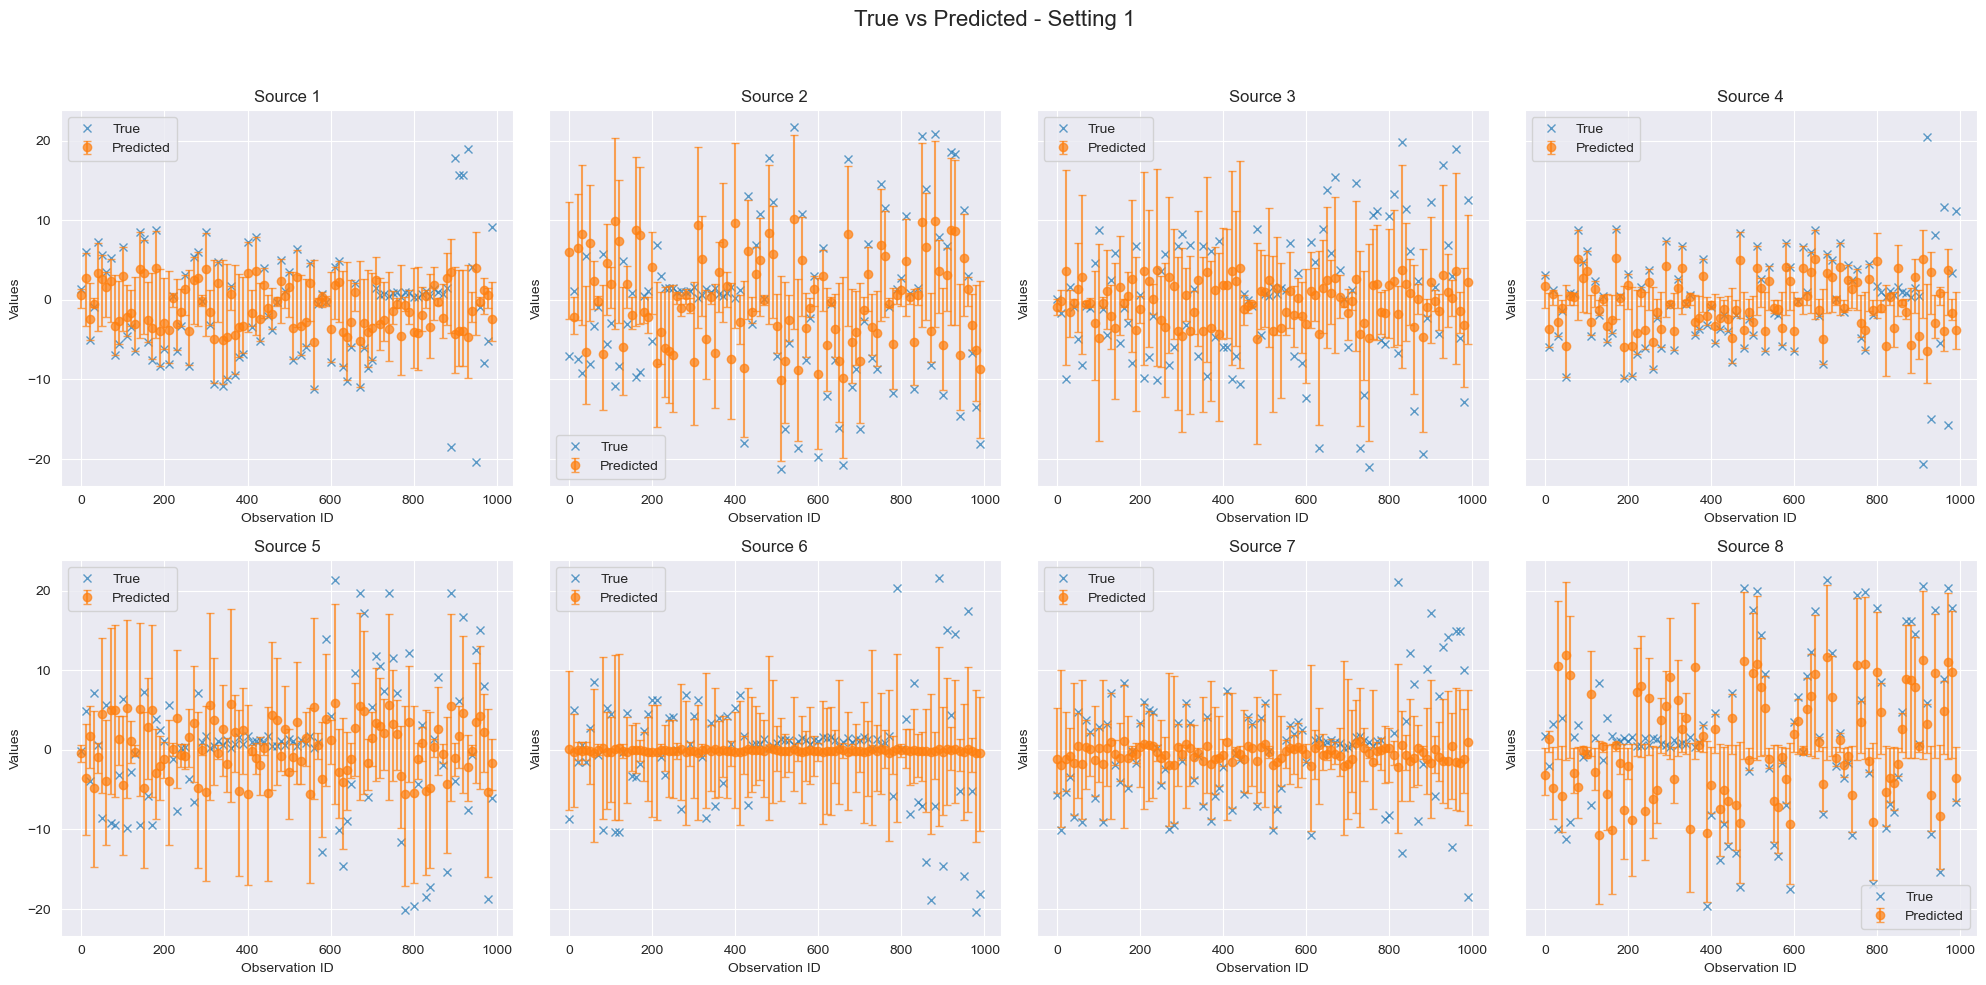

In [64]:
# Plot "True vs Predicted" with IDs on x-axis
for setting_idx, (X_setting, Y_setting, preds) in enumerate(zip(X, Y, predictions_with_ci)):
    print(f"Plotting predictions for Setting {setting_idx + 1}")
    
    # Determine grid dimensions
    n_cols = int(np.ceil(N_sources / 2))  # Two rows
    n_rows = 2 if N_sources > 1 else 1   # Ensure at least one row

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=True)
    fig.suptitle(f"True vs Predicted - Setting {setting_idx + 1}", fontsize=16)
    
    # Flatten axes for easy indexing
    axes = axes.flatten() if N_sources > 1 else [axes]
    
    for source_idx, (X_source, Y_source, pred_data) in enumerate(zip(X_setting, Y_setting, preds)):
        ax = axes[source_idx]
        pred_mean = pred_data["mean"].mean(axis=0)
        pred_ci_lower = pred_data["ci_lower"].mean(axis=0)
        pred_ci_upper = pred_data["ci_upper"].mean(axis=0)
        
        # X-axis: IDs (sample indices)
        ids = np.arange(len(Y_source))
        
        # Downsample IDs for better visualization
        step = max(1, len(ids) // 100)  # Show approximately 100 points
        ids_downsampled = ids[::step]
        true_downsampled = Y_source[::step]
        pred_downsampled = pred_mean[::step]
        ci_lower_downsampled = pred_ci_lower[::step]
        ci_upper_downsampled = pred_ci_upper[::step]
        
        # Plot true values as 'x'
        ax.plot(ids_downsampled, true_downsampled, 'x', label="True", alpha=0.7)
        
        # Plot predicted values as dots with error bars
        ax.errorbar(ids_downsampled, pred_downsampled, 
                    yerr=[pred_downsampled - ci_lower_downsampled, ci_upper_downsampled - pred_downsampled],
                    fmt='o', label="Predicted", alpha=0.7, capsize=3)
        
        ax.set_title(f"Source {source_idx + 1}")
        ax.set_xlabel("Observation ID")
        ax.set_ylabel("Values")
        ax.legend()
    
    # Remove unused subplots
    for idx in range(len(preds), len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to accommodate title
    plt.show()

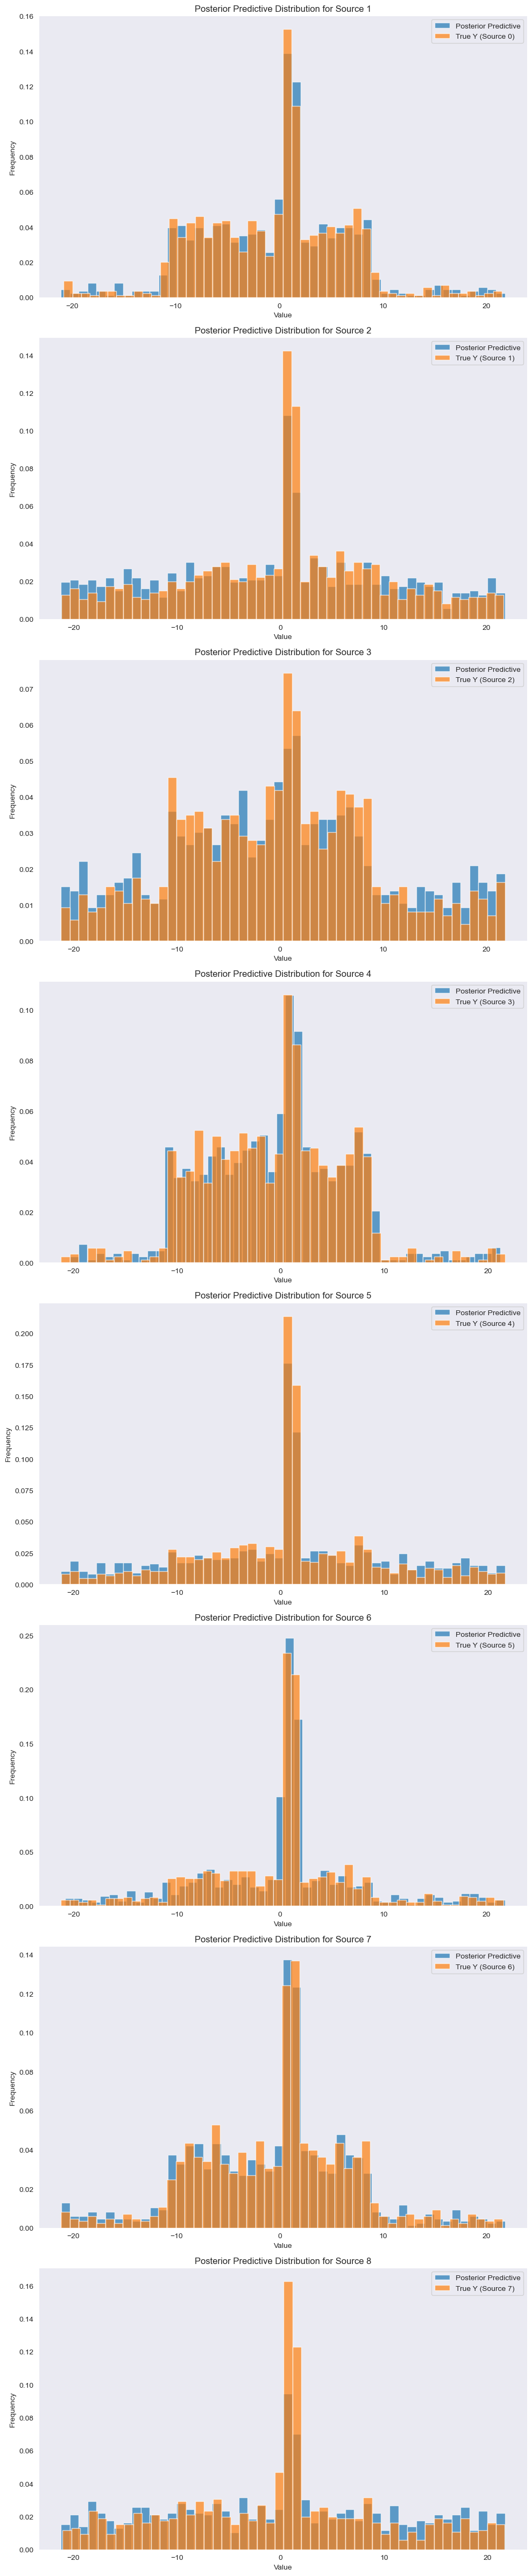

In [65]:
# Stick-breaking process
def stick_breaking(beta):
    portion_remaining = np.concatenate([[1], np.cumprod(1 - beta[:-1])])
    return beta * portion_remaining

# Reparameterize function
def reparameterize(pi):
    return pi / pi.sum()

# Function to manually sample posterior predictive distribution
def manual_posterior_predictive_for_sources(traces, X_setting, ks, N_sources, threshold=0.01):
    """
    Manually sample posterior predictive distribution for a setting with 8 sources.
    Args:
        traces: Posterior trace from PyMC.
        X_setting: List of input data from 8 sources under one setting.
        ks: Number of components in the mixture model.
        N_sources: Number of sources.
        
    Returns:
        Posterior predictive samples for each source.
    """
    # Extract posterior means for parameters
    α_mean = traces.posterior["α"].mean(dim=["chain", "draw"]).values
    β_mean = traces.posterior["β"].mean(dim=["chain", "draw"]).values
    σ_mean = traces.posterior["σ"].mean(dim=["chain", "draw"]).values
    beta_tilt_mean = traces.posterior["beta_tilt"].mean(dim=["chain", "draw"]).values
    
    # Stick-breaking process for weights
    beta_mean = stick_breaking(beta_tilt_mean)
    
    # Compute normalized weights (π_norm) for each source
    π_norms = []
    for s in range(N_sources):
        π_tilt_s = traces.posterior[f"π_{s}"].mean(dim=["chain", "draw"]).values
        π_s = stick_breaking(π_tilt_s)
        π_norm_s = reparameterize(π_s)
        π_norm_s = np.where(π_norm_s < threshold, 0, π_norm_s)
        π_norm_s = reparameterize(π_s)
        π_norms.append(π_norm_s)

    # Initialize posterior predictive samples
    posterior_predictive_samples = []

    # Generate predictions for each source
    for s in range(N_sources):
        # Compute means and standard deviations for the components
        X_s = X_setting[s]
        n_obs = len(X_s)
        mu = np.outer(X_s, β_mean) + α_mean # Broadcasting for components
        sigma = σ_mean  # Component-specific standard deviations

        # Sample posterior predictive values
        samples = np.zeros(n_obs)
        for i in range(n_obs):
            # Sample a mixture component based on π_norm
            component = np.random.choice(np.arange(ks), p=π_norms[s])
            # Sample from the selected component
            samples[i] = np.random.normal(loc=mu[i, component], scale=sigma[component])
        
        posterior_predictive_samples.append(samples)

    return posterior_predictive_samples

# Example usage
setting_index = 0  # Specify which setting to sample for
X_setting = X[setting_index]  # Features for this setting
N_sources = len(X_setting)  # Number of sources
ks = traces[setting_index].posterior["α"].shape[-1]  # Number of components

# Generate posterior predictive samples
with models[setting_index]:
    posterior_samples = manual_posterior_predictive_for_sources(
        traces[setting_index], 
        X_setting, 
        ks, 
        N_sources
    )
    
def plot_density(posterior_samples, Y_setting=None):
    """
    Plot the density of posterior predictive samples for each source.
    
    Args:
        posterior_samples: List of posterior predictive samples for each source.
        Y_setting: List of true values for each source (optional).
    """
    N_sources = len(posterior_samples)
    fig, axes = plt.subplots(N_sources, figsize=(10, 6 * N_sources))

    for s in range(N_sources):
        ax = axes[s] if N_sources > 1 else axes
        sns.kdeplot(posterior_samples[s], fill=True, label="Posterior Predictive", ax=ax)

        # Optionally plot true values
        if Y_setting is not None and Y_setting[s] is not None:
            sns.kdeplot(Y_setting[s], color="orange", fill=True, label="True Y", ax=ax, alpha=0.6)

        ax.set_title(f"Density Plot for Source {s + 1}")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

# Plotting results
fig, axes = plt.subplots(N_sources, figsize=(10, 6 * N_sources))

for s in range(N_sources):
    ax = axes[s] if N_sources > 1 else axes
    ax.hist(posterior_samples[s], bins=50, alpha=0.7, density=True,label="Posterior Predictive")
    if Y[setting_index][s] is not None:
        ax.hist(Y[setting_index][s], bins=50, alpha=0.7, density=True,label=f"True Y (Source {s})")
    ax.legend()
    ax.set_title(f"Posterior Predictive Distribution for Source {s + 1}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Frequency")
    ax.grid()

plt.tight_layout()
plt.show()

In [66]:
def manual_posterior_predictive_with_sampling(traces, X_setting, ks, N_sources, threshold=0.1, n_samples=10000):
    """
    Manually sample posterior predictive distribution using samples from the posterior distribution.
    
    Args:
        traces: Posterior trace from PyMC.
        X_setting: List of input data from 8 sources under one setting.
        ks: Number of components in the mixture model.
        N_sources: Number of sources.
        threshold: Minimum proportion threshold. Components with proportions below this value will be set to 0.
        n_samples: Number of posterior predictive samples to generate.
        
    Returns:
        Posterior predictive samples for each source.
    """
    # Extract parameter samples from the posterior trace
    α_samples = traces.posterior["α"].values  # Shape: (n_chains, n_draws, 1, ks)
    β_samples = traces.posterior["β"].values  # Shape: (n_chains, n_draws, 1, ks)
    σ_samples = traces.posterior["σ"].values  # Shape: (n_chains, n_draws, ks)
    beta_tilt_samples = traces.posterior["beta_tilt"].values  # Shape: (n_chains, n_draws, ks)

    # Reshape and combine chains and draws for simplicity
    n_chains, n_draws, *_ = α_samples.shape
    α_samples = α_samples.reshape(n_chains * n_draws, ks)
    β_samples = β_samples.reshape(n_chains * n_draws, ks)
    σ_samples = σ_samples.reshape(n_chains * n_draws, ks)
    beta_tilt_samples = beta_tilt_samples.reshape(n_chains * n_draws, ks)

    # Randomly sample from posterior draws
    sample_indices = np.random.choice(len(α_samples), size=n_samples, replace=True)

    # Initialize posterior predictive samples
    posterior_predictive_samples = []

    for s in range(N_sources):
        # Data for the current source
        X_s = np.array(X_setting[s])  # Ensure it's an array
        n_obs = len(X_s)

        # Compute weights (π_norm) for this source
        π_norm_samples = []
        for idx in sample_indices:
            beta_tilt = beta_tilt_samples[idx]
            beta = stick_breaking(beta_tilt)
            π_tilt_s = stick_breaking(beta)  # Generate weights for this source
            π_s = reparameterize(π_tilt_s)
            # Apply threshold and normalize
            π_s = np.where(π_s < threshold, 0, π_s)
            π_s = π_s / π_s.sum()
            π_norm_samples.append(π_s)

        # Generate posterior predictive samples
        samples = np.zeros((n_samples, n_obs))
        for i, idx in enumerate(sample_indices):
            α = α_samples[idx]
            β = β_samples[idx]
            σ = σ_samples[idx]
            π_norm = π_norm_samples[i]

            # Compute means for the components (shape: [n_obs, ks])
            mu = np.outer(X_s, β) + α

            for j in range(n_obs):
                # Sample a mixture component based on π_norm
                component = np.random.choice(np.arange(ks), p=π_norm)
                # Sample from the selected component
                samples[i, j] = np.random.normal(loc=mu[j, component], scale=σ[component])

        posterior_predictive_samples.append(samples)

    return posterior_predictive_samples


# Example usage

manual_samples = []    

for s in range(N_settings):
    print(f"Generating manual posterior predictive samples for setting {s + 1}")
    manual_samples.append(manual_posterior_predictive_with_sampling(
        traces[s], 
        X[s], 
        ks, 
        N_sources, 
        threshold=0.01, 
        n_samples=1000
    ))

Generating manual posterior predictive samples for setting 1


Plotting density lines for Setting 1


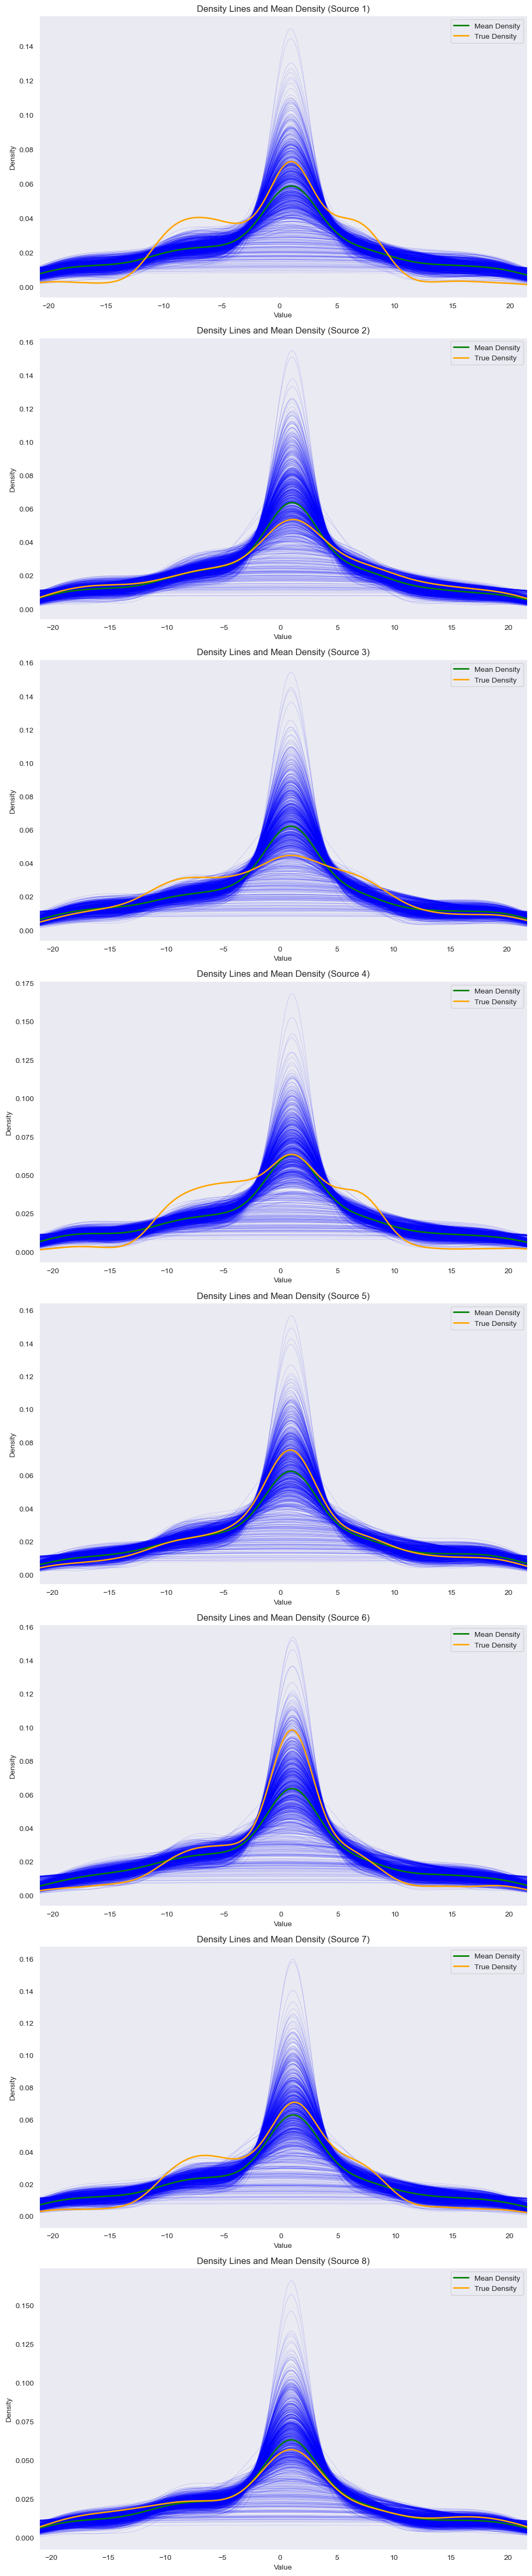

In [67]:
from scipy.stats import gaussian_kde

def plot_density_lines(posterior_samples, Y_setting=None, n_lines=100):
    """
    Plot density lines, mean density, and true density for all sources in subplots with variable x-axis ranges.
    
    Args:
        posterior_samples: List of posterior predictive samples for each source.
        Y_setting: True values for all sources (optional).
        n_lines: Number of posterior predictive samples to plot as density lines.
    """
    N_sources = len(posterior_samples)
    fig, axes = plt.subplots(N_sources, figsize=(10, 6 * N_sources))

    for s in range(N_sources):
        ax = axes[s] if N_sources > 1 else axes
        samples = posterior_samples[s]  # Get samples for the current source

        # Define source-specific range for density estimation
        all_samples = samples.flatten()
        x_min, x_max = Y_setting[s].min(), Y_setting[s].max()
        density_range = np.linspace(x_min, x_max, 500)

        # Store densities for each sample
        sample_densities = []

        # Plot density lines for posterior predictive samples
        for i in range(min(n_lines, len(samples))):
            kde = gaussian_kde(samples[i, :])
            sample_density = kde(density_range)
            ax.plot(density_range, sample_density, color="blue", alpha=0.2, lw=0.5)
            sample_densities.append(sample_density)

        # Compute and plot the mean density
        mean_density = np.mean(sample_densities, axis=0)
        ax.plot(density_range, mean_density, color="green", label="Mean Density", lw=2)

        # Plot true density if provided
        if Y_setting is not None and Y_setting[s] is not None:
            kde_true = gaussian_kde(Y_setting[s])
            true_density = kde_true(density_range)
            ax.plot(density_range, true_density, color="orange", label="True Density", lw=2)

        # Set specific x-axis range for the current source
        ax.set_xlim(x_min, x_max)

        ax.set_title(f"Density Lines and Mean Density (Source {s + 1})")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

for i in range(N_settings):
    print(f"Plotting density lines for Setting {i + 1}")
    plot_density_lines(
        manual_samples[i], 
        Y_setting=Y[i], 
        n_lines=1000
    )

Plotting density lines for Setting 1


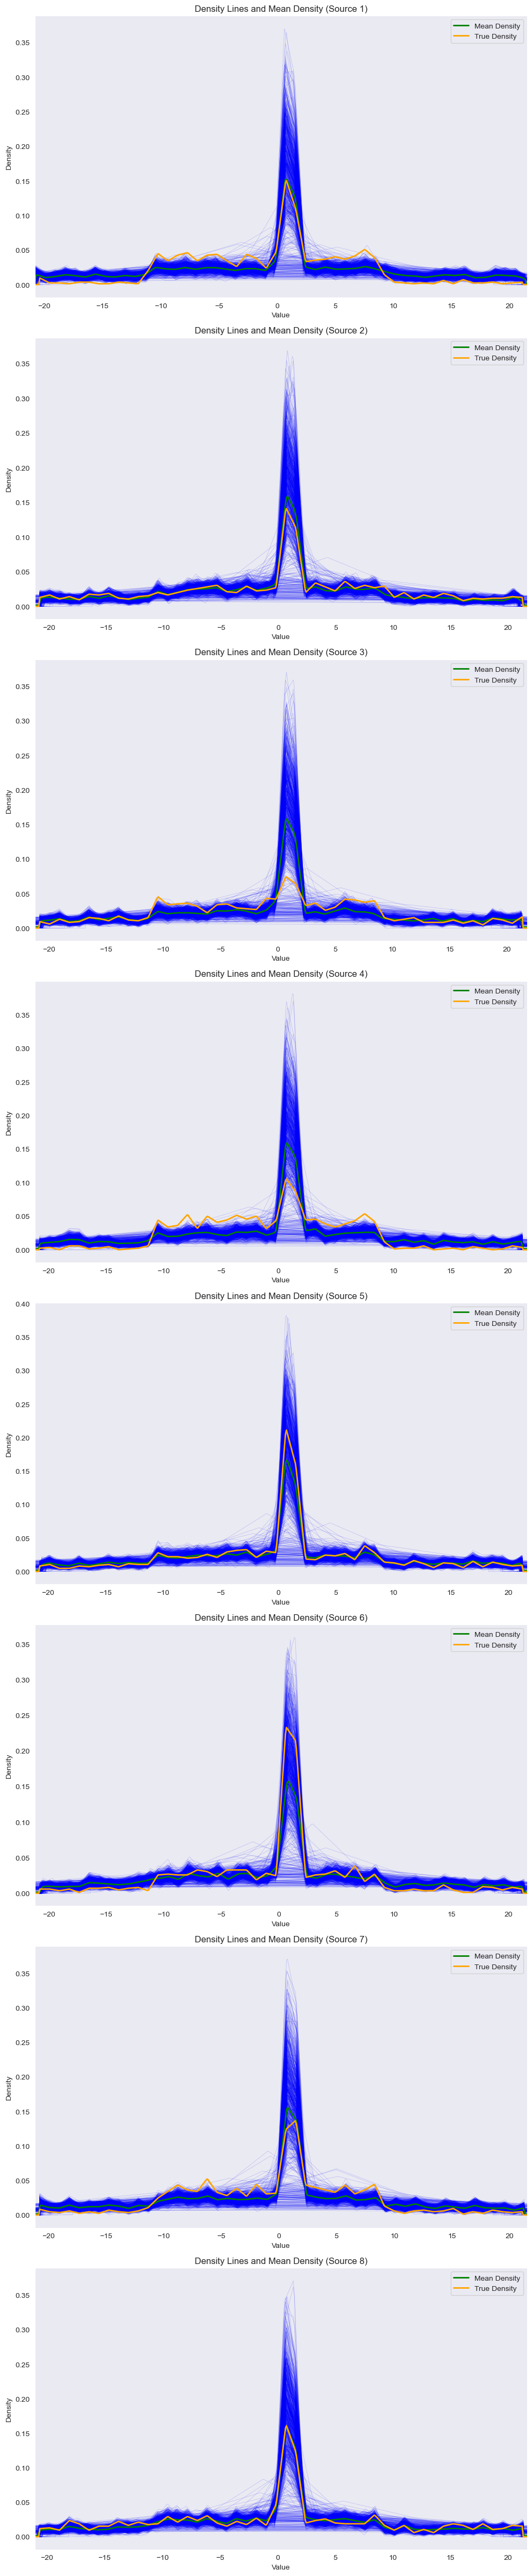

In [68]:
def plot_density_lines_histogram(posterior_samples, Y_setting=None, n_lines=100, bins=50):
    """
    Plot density lines from histograms, mean density, and true density for all sources in subplots.

    Args:
        posterior_samples: List of posterior predictive samples for each source.
        Y_setting: True values for all sources (optional).
        n_lines: Number of posterior predictive samples to plot as density lines.
        bins: Number of bins to use for the histograms.
    """
    N_sources = len(posterior_samples)
    fig, axes = plt.subplots(N_sources, figsize=(10, 6 * N_sources))

    for s in range(N_sources):
        ax = axes[s] if N_sources > 1 else axes
        samples = posterior_samples[s]  # Get samples for the current source

        # Define source-specific range for density estimation
        all_samples = samples.flatten()
        x_min, x_max = Y_setting[s].min(), Y_setting[s].max()
        density_range = np.linspace(x_min, x_max, 500)

        # Store densities for each sample
        sample_densities = []

        # Plot density lines for posterior predictive samples
        for i in range(min(n_lines, len(samples))):
            hist, bin_edges = np.histogram(samples[i, :], bins=bins, density=True)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
            # Interpolate histogram to get a smooth density line
            density = np.interp(density_range, bin_centers, hist, left=0, right=0)
            ax.plot(density_range, density, color="blue", alpha=0.2, lw=0.5)
            sample_densities.append(density)

        # Compute and plot the mean density
        mean_density = np.mean(sample_densities, axis=0)
        ax.plot(density_range, mean_density, color="green", label="Mean Density", lw=2)

        # Plot true density if provided
        if Y_setting is not None and Y_setting[s] is not None:
            true_hist, true_bin_edges = np.histogram(Y_setting[s], bins=bins, density=True)
            true_bin_centers = 0.5 * (true_bin_edges[:-1] + true_bin_edges[1:])
            true_density = np.interp(density_range, true_bin_centers, true_hist, left=0, right=0)
            ax.plot(density_range, true_density, color="orange", label="True Density", lw=2)

        # Set specific x-axis range for the current source
        ax.set_xlim(x_min, x_max)

        ax.set_title(f"Density Lines and Mean Density (Source {s + 1})")
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

# Example usage
for i in range(N_settings):
    print(f"Plotting density lines for Setting {i + 1}")
    plot_density_lines_histogram(
        manual_samples[i], 
        Y_setting=Y[i], 
        n_lines=1000,  # Adjust number of lines as needed
        bins=50       # Adjust bins as needed
    )

Plotting posterior differences for Setting 1


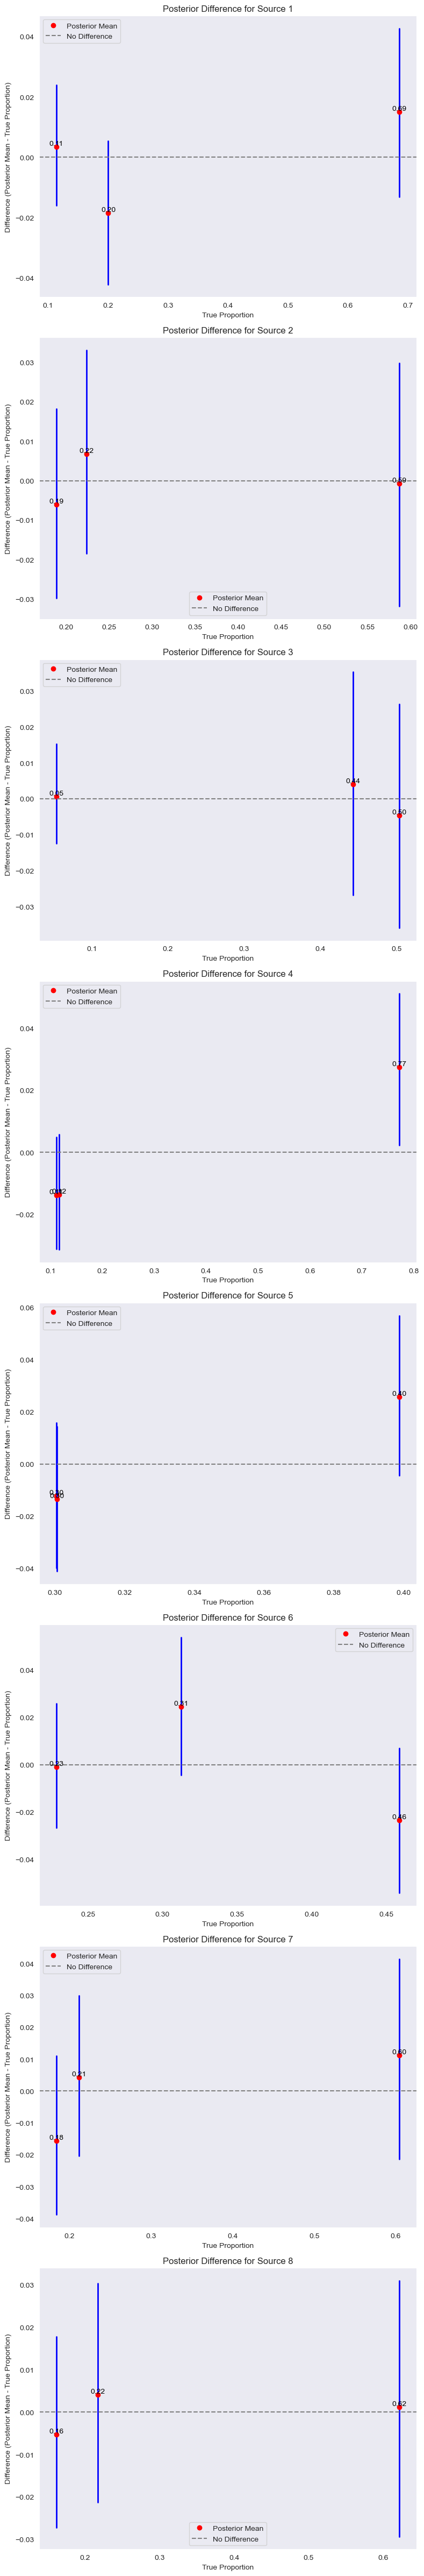

In [6]:
def plot_posterior_differences(traces, true_proportions, ks, N_sources, mapping):
    """
    Plot the difference between posterior means of π_norm_{s} and true proportions,
    considering a mapping between model components and true components, with vertical
    lines representing confidence intervals and annotated true proportions.
    
    Args:
        traces: Posterior trace from PyMC.
        true_proportions: List of true proportions for each source (length = N_sources).
        ks: Number of components in the mixture model.
        N_sources: Number of sources.
        mapping: List of mappings for each setting. Each mapping should be a dictionary
                 {model_component: true_component}.
    """
    fig, axes = plt.subplots(N_sources, figsize=(8, 6 * N_sources))
    if N_sources == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot

    for s in range(N_sources):
        ax = axes[s]
        true_prop = np.array(true_proportions[s])  # True proportions for source s

        # Extract posterior samples for π_norm_{s}
        π_norm_samples = traces.posterior[f"π_norm_{s}"].values  # Shape: [chains, draws, ks]

        # Map posterior samples to true components
        mapped_π_norm_samples = np.zeros((π_norm_samples.shape[0], π_norm_samples.shape[1], len(true_prop)))
        for model_comp, true_comp in mapping.items():
            mapped_π_norm_samples[:, :, true_comp] = π_norm_samples[:, :, model_comp]

        # Compute posterior mean and confidence intervals for mapped components
        π_norm_mean = np.mean(mapped_π_norm_samples, axis=(0, 1))  # Mean over chains and draws
        π_norm_hdi_lower = np.percentile(mapped_π_norm_samples, 2.5, axis=(0, 1))  # 2.5% percentile
        π_norm_hdi_upper = np.percentile(mapped_π_norm_samples, 97.5, axis=(0, 1))  # 97.5% percentile

        # Compute differences between posterior mean and true proportions
        differences = π_norm_mean - true_prop

        # Plot differences and confidence intervals as vertical lines
        for i, true_val in enumerate(true_prop):
            ax.plot(
                [true_val, true_val],  # x-coordinates for the vertical line
                [π_norm_hdi_lower[i] - true_val, π_norm_hdi_upper[i] - true_val],  # y-range
                color="blue", linestyle="-", linewidth=2
            )
            ax.plot(
                true_val, differences[i], "o", color="red", label="Posterior Mean" if i == 0 else ""
            )
            # Annotate true proportion
            ax.text(
                true_val, differences[i], 
                f"{true_val:.2f}", 
                fontsize=10, color="black", ha="center", va="bottom"
            )

        ax.axhline(0, color="gray", linestyle="--", label="No Difference")
        ax.set_title(f"Posterior Difference for Source {s + 1}")
        ax.set_xlabel("True Proportion")
        ax.set_ylabel("Difference (Posterior Mean - True Proportion)")
        ax.legend()
        ax.grid()

    plt.tight_layout()
    plt.show()

# Example usage
true_proportions = [
    [0.02001195, 0.67261832, 0.30736973],  # Source 1
    [0.25890493, 0.00437364, 0.73672143],  # Source 2
    [0.80260249, 0.10723697, 0.09016054],  # Source 3
    [0.15474873, 0.27706078, 0.5681905],   # Source 4
    [0.30468598, 0.18545189, 0.50986213],  # Source 5
    [0.15780486, 0.36292607, 0.47926907],  # Source 6
    [0.25697713, 0.64902589, 0.09399698],  # Source 7
    [0.43310548, 0.53836359, 0.02853093],  # Source 8
]

ks = 5  # Number of components in the model
N_sources = 8  # Number of sources

# Mapping for model components to true components (for all settings)
mapping = {0: 2, 1: 1, 2: 0}  # Components 3 and 4 are ignored

# Plot posterior differences for each setting
for i, trace in enumerate(traces):
    print(f"Plotting posterior differences for Setting {i + 1}")
    plot_posterior_differences(trace, Proportions, ks, N_sources, mapping)